# Sunseeker
_J. Nathan Matias,  12.22.2018_

Estimate the relative cost of trips that increase probability of seeing sun (or shade) in January.

In [159]:
import csv, re, sys, time, copy
import matplotlib.pyplot as plt
from astropy.io import ascii
import pandas as pd
from collections import Counter
from geopy.geocoders import Nominatim
import geopy.distance
from calendar import monthrange
from time import strptime

geolocator = Nominatim(user_agent="sunseeker 0.1a")

## NOTE: pctpos15.dat is calculated from clpcdy15.dat
## and for the purposes of this analysis, we workf rom
## clpcdy15.dat, while including code for pctpos15

# Load Sun Data

In [261]:
sun_data = {}
with(open('data/clpcdy15.csv', 'r')) as f:
    for row in csv.DictReader(f):
        city_row = {}
        citykey = row['CITYKEY']
        city = row['CITYKEY'][5:].strip()
        city = city.replace(" AP", "").strip()
        city = city.replace("-ST.PAUL", "")
        city = city.replace("NAT'L", "")
        city = city.replace("DULLES", "")
        city = city.replace("I T", "")
        city = city.replace("/HARRISBURG I APT", "")
        city = city.replace("-WNSTN-SALM-HGHPT", "")
        city = city.replace("(LAGUARDIA )", "")
        city = city.replace("(JFK )", "")
        city = city.replace("SEA-TAC ", "")
        city = city.replace(" (NORTH)", "")
        city = city.replace("-FORT WORTH", "")
        city = city.replace("-SPARTANBURG", "")
        city = city.replace("/HARRISBURG", "")
        city = city.replace("-JHNSN CTY-KNGSPRT", "")
        city = city.replace("GREATER", "")
        city = city.replace("IS.", "ISLAND")
        city = city.replace(" C.O.", "")
        city =  city.replace(", CA", ", CALIFORNIA")
        city = city.replace(" ,", ",")
        city = re.sub('  +',' ', city)
        city_row['CITY'] = city
        for prefix in ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', "ANNUAL"]:
            clkey = prefix + "_CL"  
            pckey = prefix + "_PC"
            
            row[clkey] = row[clkey].strip()
            row[pckey] = row[pckey].strip()
            
            if(prefix == "ANNUAL"):
                days_in_period =  365
            else:
                month = strptime(prefix,'%b').tm_mon
                year = 2015
                days_in_period = monthrange(year, month)[1]
            
            ## record the chance of some sun per month
            if(clkey in row.keys() and pckey in row.keys() and
               row[clkey] !="*" and row[pckey] != "*"):
                city_row[prefix] = round(float(int(row[clkey]) +  int(row[pckey])) / float(days_in_period)*100.)
            else:
                city_row[prefix] = None
                
        sun_data[city] = city_row

## Plot Sun Data

In [251]:
sun_df = pd.DataFrame(list(sun_data.values()))

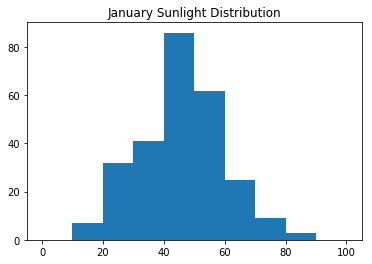

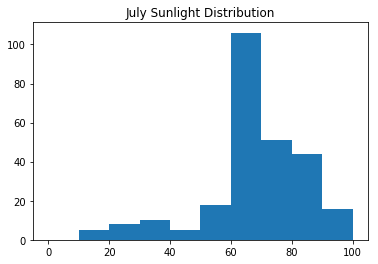

In [252]:
plt.hist(sun_df['JAN'], range=(0,100))
plt.title("January Sunlight Distribution")
plt.show()

plt.hist(sun_df['JUL'], range=(0,100))
plt.title("July Sunlight Distribution")
plt.show()

# Create a City Distance Dataset
* Add lat and long to each sun location
* calculate a dataset of all possible distances using  the lat and long

In [263]:
#sun_data.keys()

In [264]:
for city, row in sun_data.items():
    if('location' not in row.keys()):
        location = geolocator.geocode(city)
        if(location is not None):
            row['lat']  = location.latitude
            row['long'] = location.longitude
            row['location'] = location
            print(city)
        else:
            row['lat'] = None
            row['long']  = None
            row['location'] = None
            print("NULL RESULT: {0}".format(city))
        sys.stdout.flush()
        time.sleep(1)

BIRMINGHAM,AL
HUNTSVILLE, AL
NULL RESULT: MOBILE, AL
MONTGOMERY, AL
ANCHORAGE, AK
ANNETTE, AK
BARROW, AK
BETHEL, AK
BETTLES,AK
BIG DELTA,AK
COLD BAY,AK
FAIRBANKS, AK
GULKANA,AK
HOMER, AK
JUNEAU, AK
KING SALMON, AK
KODIAK, AK
KOTZEBUE, AK
MCGRATH, AK
NOME, AK
ST. PAUL ISLAND, AK
TALKEETNA, AK
UNALAKLEET, AK
VALDEZ, AK
YAKUTAT, AK
FLAGSTAFF, AZ
PHOENIX, AZ
TUCSON, AZ
WINSLOW, AZ
YUMA, AZ
FORT SMITH, AR
LITTLE ROCK, AR
BAKERSFIELD, CALIFORNIA
BISHOP, CALIFORNIA
BLUE CANYON, CALIFORNIA
EUREKA, CALIFORNIA.
FRESNO, CALIFORNIA
LONG BEACH, CALIFORNIA
LOS ANGELES, CALIFORNIA
MOUNT SHASTA, CALIFORNIA
REDDING, CALIFORNIA
SACRAMENTO, CALIFORNIA
SAN DIEGO, CALIFORNIA
SAN FRANCISCO, CALIFORNIA
SANTA MARIA, CALIFORNIA
STOCKTON, CALIFORNIA
NULL RESULT: ALAMOSA, CO
COLORADO SPRINGS, CO
DENVER, CO
GRAND JUNCTION, CO
PUEBLO, CO
BRIDGEPORT, CT
HARTFORD, CT
WILMINGTON, DE
WASHINGTON, D.C.
APALACHICOLA, FL
DAYTONA BEACH, FL
FORT MYERS, FL
JACKSONVILLE, FL
KEY WEST, FL
MIAMI, FL
ORLANDO, FL
PENSACOLA, FL
TAL

In [142]:
# ### CORRECT SAN FRANCISCO LOCATION
# sfloc = geolocator.geocode("San Francisco")
# sun_data['SAN FRANCISCO,CA']['lat']      = sfloc.latitude
# sun_data['SAN FRANCISCO,CA']['long']     = sfloc.longitude
# sun_data['SAN FRANCISCO,CA']['location'] = sfloc

In [268]:
#[(k,v['location']) for k,v in sun_data.items()]
#sun_data['SAN FRANCISCO, CALIFORNIA']

## Create a Sun + Distance Dataset
One row for each place  -> sunlight combination

In [270]:
sun_paths = []

# for every origin city
for o_name, o_city in sun_data.items():
    # create an "origin row" dict for each value in the dict
    # except for location, which is an object we won't be
    # saving, beyond its use to help calculate distance
    o_row = {}
    for key in [x for x in o_city.keys() if x != "location"]:
        o_row["origin_" + key] = o_city[key]
        o_row['origin_LOC'] = o_name.upper()
    
    # for every destination city
    for d_name, d_city in sun_data.items():
        if(o_name == d_name or 
            o_city['location'] is None or 
            d_city['location'] is None):
            continue
        # create a path object, starting with the origin row
        # and storing information about the destination
        sun_path = copy.copy(o_row)
        for key in [x for x in d_city.keys() if x != "location"]:
            sun_path["dest_" + key] = d_city[key]
            o_row['dest_LOC'] = d_name.upper()
        
        sun_path['distance_miles']  = geopy.distance.distance(
            o_city['location'].point, 
            d_city['location'].point
        ).miles
        
        sun_paths.append(sun_path)
print("Created {0} paths between {1} locations".format(len(sun_paths), len(sun_data)))

Created 62750 paths between 268 locations


# Plot and Summarize Distance and Sunlight from an origin city

In [347]:
def plot_january_sun(origin_city, sun_paths, sun_data, month_key, max_miles):
    origin_sun_paths = []
    origin_city =  origin_city.lower().strip()
    for path in sun_paths:
        if path['origin_LOC'].lower().strip() == origin_city:
            origin_sun_paths.append(path)
    print("Found {0} paths originating in {1}".format(len(origin_sun_paths), origin_city))
    
    
    month_sun = 100
    annual_sun = 100
    city_name = None
    for key in [k for k in sun_data.keys() if k in [x for x in sun_data.keys() if x.lower().strip() == origin_city]]:
        month_sun = sun_data[key][month_key]
        city_name = key
        annual_sun = sun_data[key]['ANNUAL']
    print("Average {3} sun: {0}% in {1}, with annual sun pct of {2}%".format(
        month_sun, city_name, annual_sun, month_key))
    
    fig = plt.figure(figsize=(18, 4))
    plt.scatter([x['distance_miles'] for x in origin_sun_paths if x['distance_miles'] < max_miles], 
             [x['dest_' + month_key] for x in origin_sun_paths if x['distance_miles'] < max_miles]) 
    plt.axvline(x=0, color="black")
    plt.axvline(x=60, color="gray", linestyle="dashed")
    plt.axvline(x=120, color="gray", linestyle="dashed")
    plt.axvline(x=180, color="gray", linestyle="dashed")
    plt.axhline(y=month_sun, color="red", linestyle="dashed")
    plt.xlabel("Miles Distance")
    plt.ylabel("% Sun in {0}".format(month_key))
    plt.title("{0}: {1}% days with sun in {2}. {3}% days with sun overall".format(
        city_name, month_sun, month_key, annual_sun
    ))
    plt.show()

Found 250 paths originating in boston, ma
Average JAN sun: 52% in BOSTON, MA, with annual sun pct of 55%


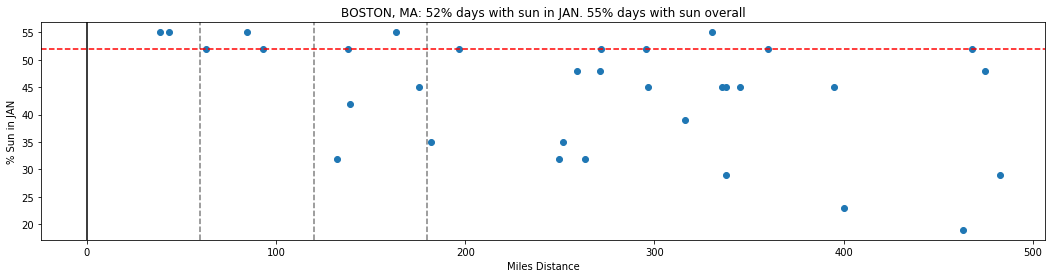

In [362]:
plot_january_sun("Boston, MA", sun_paths, sun_data, "JAN", 500)

In [351]:
### SCRATCH AREA
# with(open('data/pctpos15.dat', 'r')) as f:        

#     sun_data   = {}
#     sun_keys   = None
#     sun_header = None

#     counter = 1
#     for line in f:
#         if(counter == 1):
#             sun_header = line
#             sun_keys = re.sub('  +',';',  sun_header).strip().split(";")
#             sun_keys.remove("")
#         else:
#             sun_values = {}
#             sun_values["NUM"]= line[0:4]
#             sun_values["LOC"] = line[5:37].strip()
#             regions = line[5:37].strip().split(",")
#             sun_values["CITY"]   = regions[0]
#             sun_values["REGION"] = regions[1]

#             sun_values[sun_keys[0]] = line[38:38+12].strip()
#             i = 38 + 12 + 1
#             key_counter = 1
#             while(len(line) >= i+6):
#                 value = line[i:i+6].strip()
#                 try:
#                     value = int(value)
#                 except:
#                     value = None
#                 sun_values[sun_keys[key_counter]] = value
#                 key_counter += 1
#                 i += 6
            
#             sun_data[sun_values["LOC"]] = sun_values
#         counter += 1
        
# sun_cities = [x.lower().replace(",",", ") for x in list(sun_data.keys())]